In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### our dataset

In [2]:
def preprocess_time(year, month, day, hour, minute, s):
    """
    get time in format "1990-01-01T00:00:00Z"

    Args:
        year (_type_): _description_
        month (_type_): _description_
        day (_type_): _description_
        hour (_type_): _description_
        minute (_type_): _description_
        s (_type_): _description_

    Returns:
        str: formatted time
    """
    f0 = lambda x: f"0{int(x)}" if x < 10 else str(int(x))
    
    year = str(int(year))
    month = f0(month)
    day = f0(day)
    hour = f0(hour)
    minute = f0(minute)
    s = f0(s)
    
    return f"{year}-{month}-{day}T{hour}:{minute}:{s}Z"

def get_formatted_dataset(df, min_magnitude=0.):
    """
    formatting dataset for earthquake_jp preprocess() function.

    Args:
        df (pd.DataFrame): earthquakes dataset
        
        dataset in format:
        YYYY  MM  DD  HH  mm  ssss     LAT     LONG  Depth  Class
        0  2004   3   6  18   4   9.0  36.360  136.571    6.2    0.7
        1  2004   3   6  18   5  40.0  37.007  138.709    9.8    0.7
        
    Returns:
        pd.DataFrame: formatted dataset with columns ["time", "longitude", "latitude", "magnitude"]
    """
    
    df = df[df["Class"] > min_magnitude].reset_index(drop=True)
    df["time"] = df[["YYYY", "MM", "DD", "HH", "mm", "ssss"]].apply(
        lambda x: preprocess_time(*x),
        axis = 1
    )
    df = df.rename(
        columns={
            "LAT": "latitude", 
            "LONG": "longitude", 
            "Class": "magnitude"}
        )
    df["place"] = "Japan"
    df = df[["time", "longitude", "latitude", "magnitude", "place"]]
    
    return df

def preprocess(
    data_path="earthquakes/1990_2019.csv", 
    save_path="earthquakes/earthquakes_jp.npz",
    basedate_str="1990-01-01T00:00:00Z",
    ):
    df = pd.read_csv(data_path)
    
    # filter earthquakes in Japan
    df = df[df["place"].str.contains("Japan")]
    df = df[["time", "longitude", "latitude"]]

    # write time as a days since basedate
    basedate = pd.Timestamp((basedate_str))
    df["time_datetime"] = pd.to_datetime(df["time"])
    df["time"] = df["time_datetime"].apply(lambda x: (x - basedate).total_seconds() / 60 / 60 / 24)  # days
    delta_days = int((df["time_datetime"].max()-pd.to_datetime(basedate)).days / 7)
    df = df[["time", "longitude", "latitude"]]

    sequences = {}
    for weeks in range(delta_days + 1):
        date = basedate + pd.Timedelta(weeks=weeks)

        if date.year == 2011:
            continue
        if date.year == 2010 and date.month in [11, 12]:
            continue

        seq_name = f"{date.year}{date.month:02d}" + f"{date.day:02d}"

        start = (date - basedate).days
        end = (date + pd.Timedelta(days=30) - basedate).days

        df_range = df[df["time"] >= start]
        df_range = df_range[df_range["time"] < end]
        df_range["time"] = df_range["time"] - start

        seq = df_range.to_numpy().astype(np.float64)

        t, x = seq[:, 0:1], seq[:, 1:3]

        sequences[seq_name] = np.concatenate([t, x], axis=1)

    np.savez(save_path, **sequences)
    print("Preprocessing complete.")

In [3]:
DATA_ORIG_PATH = "data/catalogues/originalCat.csv"
DATA_WITHOUT_AFT_PATH = "data/catalogues/withoutAftCat.csv"
OUR_ORIG_DF = "data/prepared_datasets/original_magn_3_5_dataset.csv"
OUR_WITHOUT_AFT_DF = "data/prepared_datasets/without_aft_magn_3_5_dataset.csv"

### оригинальный датасет

#### magn 3.5

In [4]:
orig_df = pd.read_csv(DATA_ORIG_PATH, sep=' ')
print(len(orig_df))
orig_df.head(2)

3234319


,YYYY,MM,DD,HH,mm,ssss,LAT,LONG,Depth,Class
0,2004,3,6,18,4,9.0,36.360,136.571,6.2,0.7
1,2004,3,6,18,5,40.0,37.007,138.709,9.8,0.7


In [5]:
orig_df["Class"].unique()

array([ 0.7,  0. ,  0.2,  1. ,  0.6,  2.8,  1.4,  1.5, -0.1,  1.7,  1.8,
        0.9,  1.1, -0.4,  0.4,  0.5,  0.8,  0.1,  2.5,  2. ,  3. ,  3.4,
        0.3,  1.2,  2.2,  2.1, -0.2, -0.3,  1.6,  1.3,  2.3,  1.9,  3.9,
        3.8,  2.4,  2.6,  4.1,  3.1,  2.9, -0.5,  3.3, -0.6,  3.6,  2.7,
        3.2,  4.4,  3.7,  3.5,  5.3,  4.3, -1. ,  4. , -0.7, -0.8,  4.7,
        4.9,  4.2,  4.5,  5.8,  5.1, -0.9,  4.8,  4.6,  5. ,  5.4,  5.9,
        6.7,  5.6,  5.2,  5.5,  7.1,  7.4,  6.5,  5.7,  6.8,  6.3,  6. ,
        6.1,  7. ,  7.2,  6.6,  6.2,  6.9,  6.4,  7.3,  9. ,  7.6,  8.1])

In [6]:
len(orig_df[orig_df["Class"] > 3.5])

35854

In [7]:
len(orig_df[orig_df["Class"] > 6])

243

In [8]:
formatted_orig_df = get_formatted_dataset(orig_df, min_magnitude=3.5)
formatted_orig_df.to_csv(OUR_ORIG_DF)
formatted_orig_df.head(2)

,time,longitude,latitude,magnitude,place
0,2004-03-07T05:09:36Z,141.699,38.958,3.9,Japan
1,2004-03-07T06:49:53Z,139.395,35.609,3.8,Japan


In [9]:
formatted_orig_df.tail(2)

,time,longitude,latitude,magnitude,place
35852,2023-07-10T15:25:48Z,140.962,37.031,4.0,Japan
35853,2023-07-10T17:59:16Z,139.784,27.363,3.7,Japan


In [10]:
formatted_orig_df["time"].min()

'2004-03-07T05:09:36Z'

In [11]:
formatted_orig_df["time"].max()

'2023-07-10T17:59:16Z'

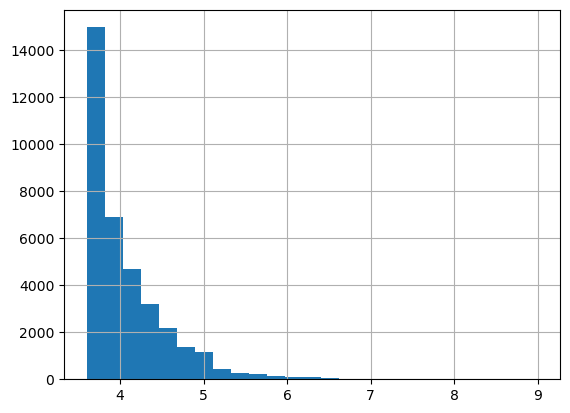

In [12]:
formatted_orig_df["magnitude"].hist(bins=25);

In [13]:
%%time
preprocessed_orig_df = preprocess(
    data_path=OUR_ORIG_DF, 
    save_path="data/earthquakes/earthquakes_orig_magn_3_5.npz",
    basedate_str="2004-01-01T00:00:00Z",
)

Preprocessing complete.
CPU times: user 513 ms, sys: 48.3 ms, total: 561 ms
Wall time: 592 ms


#### magn 6

In [14]:
formatted_orig_df = get_formatted_dataset(orig_df, min_magnitude=6)
formatted_orig_df.to_csv(OUR_ORIG_DF)
formatted_orig_df.head(2)

,time,longitude,latitude,magnitude,place
0,2004-05-30T00:56:06Z,141.859,34.108,6.7,Japan
1,2004-09-05T14:07:07Z,136.798,33.033,7.1,Japan


In [15]:
len(formatted_orig_df)

243

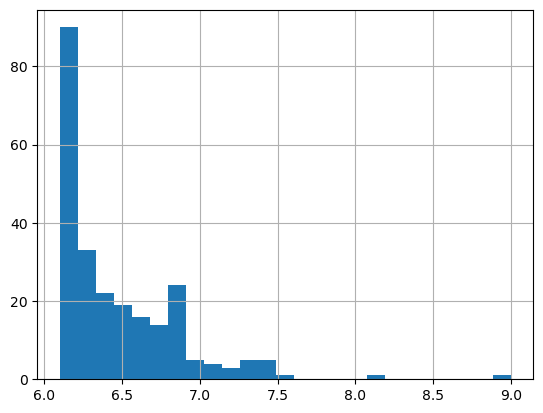

In [16]:
formatted_orig_df["magnitude"].hist(bins=25);

In [17]:
formatted_orig_df.head()

,time,longitude,latitude,magnitude,place
0,2004-05-30T00:56:06Z,141.859,34.108,6.7,Japan
1,2004-09-05T14:07:07Z,136.798,33.033,7.1,Japan
2,2004-09-05T18:57:16Z,137.141,33.138,7.4,Japan
3,2004-09-07T03:29:36Z,137.293,33.209,6.5,Japan
4,2004-09-08T18:58:23Z,137.287,33.118,6.5,Japan


In [18]:
formatted_orig_df["time"].min()

'2004-05-30T00:56:06Z'

In [19]:
%%time
preprocessed_orig_df = preprocess(
    data_path=OUR_ORIG_DF, 
    save_path="data/earthquakes/earthquakes_orig_magn_6.npz",
    basedate_str="2004-05-30T00:00:00Z",
)

Preprocessing complete.
CPU times: user 235 ms, sys: 12.8 ms, total: 248 ms
Wall time: 246 ms


### датасет без афтершоков

#### magn 3.5

In [20]:
without_aft_df = pd.read_csv(DATA_WITHOUT_AFT_PATH, sep=' ')
print(len(without_aft_df))
without_aft_df.head(2)

1273735


,YYYY,MM,DD,HH,mm,ssss,LAT,LONG,Depth,Class
0,2004,3,6,18,4,9.0,36.360,136.571,6.2,0.7
1,2004,3,6,18,5,40.0,37.007,138.709,9.8,0.7


In [21]:
formatted_without_aft_df = get_formatted_dataset(without_aft_df, min_magnitude=3.5)
formatted_without_aft_df.to_csv(OUR_WITHOUT_AFT_DF)
formatted_without_aft_df.head(2)

,time,longitude,latitude,magnitude,place
0,2004-03-07T05:09:36Z,141.699,38.958,3.9,Japan
1,2004-03-07T06:49:53Z,139.395,35.609,3.8,Japan


In [22]:
without_aft_df["YYYY"].unique()

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [23]:
formatted_without_aft_df["time"].min()

'2004-03-07T05:09:36Z'

In [24]:
%%time
preprocessed_orig_df = preprocess(
    data_path=OUR_WITHOUT_AFT_DF, 
    save_path="data/earthquakes/earthquakes_without_aft_magn_3_5.npz",
    basedate_str="2004-03-01T00:00:00Z",
)

Preprocessing complete.
CPU times: user 296 ms, sys: 14.8 ms, total: 310 ms
Wall time: 332 ms


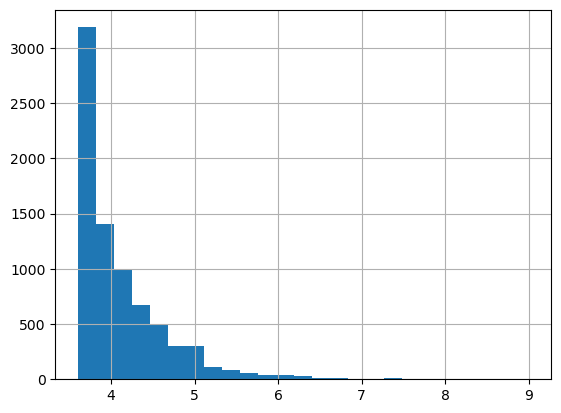

In [25]:
formatted_without_aft_df["magnitude"].hist(bins=25);

7780

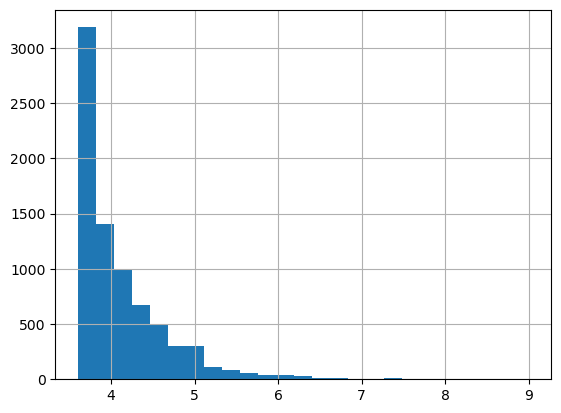

In [26]:
formatted_without_aft_df[formatted_without_aft_df["magnitude"] > 2.7]["magnitude"].hist(bins=25);
len(formatted_without_aft_df[formatted_without_aft_df["magnitude"] > 2.7])

#### magn 6

In [27]:
formatted_without_aft_df = get_formatted_dataset(without_aft_df, min_magnitude=6)
formatted_without_aft_df.to_csv(OUR_WITHOUT_AFT_DF)
formatted_without_aft_df.head(2)

,time,longitude,latitude,magnitude,place
0,2004-05-30T00:56:06Z,141.859,34.108,6.7,Japan
1,2004-09-05T14:07:07Z,136.798,33.033,7.1,Japan


In [28]:
len(formatted_without_aft_df)

105

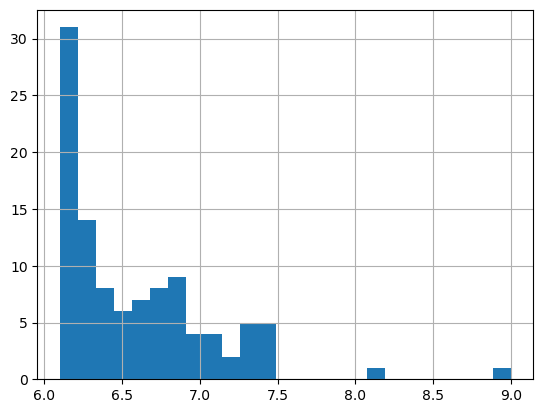

In [29]:
formatted_without_aft_df["magnitude"].hist(bins=25);

In [30]:
formatted_without_aft_df["time"].min()

'2004-05-30T00:56:06Z'

In [31]:
%%time
preprocessed_orig_df = preprocess(
    data_path=OUR_WITHOUT_AFT_DF, 
    save_path="data/earthquakes/earthquakes_without_aft_magn_6.npz",
    basedate_str="2004-05-30T00:00:00Z",
)

Preprocessing complete.
CPU times: user 245 ms, sys: 10.7 ms, total: 255 ms
Wall time: 253 ms


### датасет из статьи

In [34]:
df = pd.read_csv("earthquakes/1990_2019.csv")
df = df[df["place"].str.contains("Japan")]

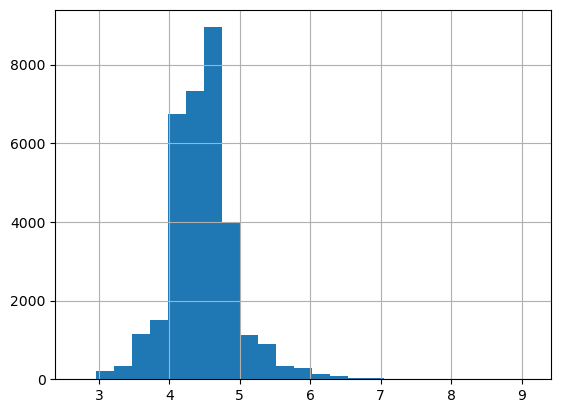

In [35]:
df["mag"].hist(bins=25);

In [36]:
df["mag"].min()

2.7

In [37]:
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,1990-01-01T09:03:12.880Z,36.417,140.568,67.9,4.8,mb,NaN,NaN,NaN,1.2,...,2014-11-07T00:45:26.659Z,"3 km NE of Hitachi-Naka, Japan",earthquake,NaN,6.5,NaN,12.0,reviewed,us,us
1,1990-01-02T16:26:37.730Z,43.420,146.063,73.4,4.6,mb,NaN,NaN,NaN,0.8,...,2014-11-07T00:45:27.543Z,"40 km ENE of Nemuro, Japan",earthquake,NaN,9.8,NaN,10.0,reviewed,us,us
2,1990-01-03T08:53:38.930Z,35.457,141.272,10.0,4.3,mb,NaN,NaN,NaN,1.1,...,2014-11-07T00:45:27.933Z,"50 km SE of Hasaki, Japan",earthquake,NaN,NaN,NaN,1.0,reviewed,us,us
3,1990-01-04T12:16:38.380Z,36.342,141.408,55.1,4.4,mb,NaN,NaN,NaN,1.1,...,2014-11-07T00:45:28.402Z,"73 km ESE of Hitachi, Japan",earthquake,NaN,11.8,NaN,4.0,reviewed,us,us
4,1990-01-04T23:25:57.190Z,32.381,138.821,247.7,5.2,mw,NaN,NaN,NaN,0.9,...,2016-11-09T21:35:52.211Z,"252 km SSE of ?yama, Japan",earthquake,NaN,3.6,NaN,NaN,reviewed,us,hrv


In [38]:
df.tail()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
37576,2019-12-30T04:32:31.444Z,38.5443,142.0323,51.00,4.4,mb,NaN,136.0,3.012,0.75,...,2020-03-14T22:23:18.040Z,"64 km SSE of ?funato, Japan",earthquake,7.0,5.2,0.108,25.0,reviewed,us,us
37577,2019-12-30T06:22:42.354Z,22.2624,143.4716,120.66,4.3,mb,NaN,78.0,4.952,0.59,...,2020-03-14T22:23:16.040Z,"Volcano Islands, Japan region",earthquake,12.8,6.7,0.090,35.0,reviewed,us,us
37578,2019-12-30T14:36:56.017Z,33.8453,136.9800,368.29,4.1,mb,NaN,56.0,1.297,0.66,...,2020-03-14T22:23:10.040Z,"71 km S of Toba, Japan",earthquake,7.9,2.4,0.080,42.0,reviewed,us,us
37579,2019-12-30T18:43:36.410Z,28.8759,142.4958,10.00,4.9,mb,NaN,105.0,1.794,0.58,...,2020-03-14T22:23:05.040Z,"Bonin Islands, Japan region",earthquake,3.6,1.8,0.046,149.0,reviewed,us,us
37580,2019-12-31T17:10:14.848Z,30.1060,142.4452,10.00,4.7,mb,NaN,110.0,3.008,0.98,...,2020-03-14T22:22:51.040Z,"Izu Islands, Japan region",earthquake,7.6,1.6,0.077,51.0,reviewed,us,us


In [39]:
# filter earthquakes in Japan
df = df[df["place"].str.contains("Japan")]
df = df[["time", "longitude", "latitude"]]
len(df)

33178

### split

In [42]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
from viz_dataset import load_data
import datetime
%matplotlib inline

In [43]:
def calc_dataset_stats(train_set, test_set, val_set):
    stats_dict = {}
    sets = {
        "train": train_set,
        "test": test_set,
        "val": val_set
    }
    columns = ["len", "mean", "median", "min", "max"]
    all_shapes = []
    for set_name, set_i in sets.items():
        shapes = []
        for i in range(len(set_i)):
            shapes.append(set_i[i].shape[0])
        # shapes = np.asarray(shapes)
        stats_dict[set_name] = [
            len(set_i), np.mean(shapes), np.median(shapes), 
            np.min(shapes), np.max(shapes), 
            # len(shapes[shapes==0])
            ]
        all_shapes.extend(shapes)
    print(np.sum(all_shapes)) # кол-во событий суммарно (конечно с повторениями)
    stats_df = pd.DataFrame.from_dict(stats_dict, columns=columns, orient="index")
    return stats_df

def plot_timeline(train_set, val_set, test_set, xlim=None, title=None, save_dir=None, show=True):
    train_date_sequence_dict = dict(zip(train_set.file_splits["train"], train_set))
    val_date_sequence_dict = dict(zip(val_set.file_splits["val"], val_set))
    test_date_sequence_dict = dict(zip(test_set.file_splits["test"], test_set))

    get_str_date_list = lambda x: [f"{d[:4]}-{d[4:6]}-{d[6:]}" for d in np.sort(list(x))]

    train_dates = get_str_date_list(train_date_sequence_dict.keys())
    val_dates = get_str_date_list(val_date_sequence_dict.keys())
    test_dates = get_str_date_list(test_date_sequence_dict.keys())

    sets_dict = {
        "train": train_dates,
        "val": val_dates,
        "test": test_dates,
    }

    sets_data_list = []
    for set_name, set_dates in sets_dict.items():
        for dt in set_dates:
            start_dt = dt
            finish_dt = (pd.to_datetime(start_dt) + pd.Timedelta(days=30)).strftime('%Y-%m-%d')
            time_interval = dict(start=start_dt, finish=finish_dt, dataset=set_name)
            sets_data_list.append(time_interval)
    df = pd.DataFrame(sets_data_list)

    fig = px.timeline(df, x_start="start", x_end="finish", y="dataset", color="dataset", opacity=0.5, title=title)
    if xlim is not None:
        fig.update_xaxes(range=xlim)

    if save_dir is not None:
        filename = title.replace(",", "").replace(" ", "_")
        fig.write_image(os.path.join(save_dir, f"{filename}.png"), width=900, height=350)

    if show:
        fig.show()

In [12]:
PLOTLY_SAVE_DIR = "data/plotly_timeline"

In [58]:
data = "earthquakes_jp"
paper_split = True
train_set = load_data(data, split="train", earthquakes_paper_split=paper_split)
val_set = load_data(data, split="val", earthquakes_paper_split=paper_split)
test_set = load_data(data, split="test", earthquakes_paper_split=paper_split)

In [61]:
stats_df = calc_dataset_stats(train_set, test_set, val_set)
stats_df

79844


,len,mean,median,min,max
train,950,75.951579,70.0,19,339
test,50,79.360000,70.0,32,545
val,50,74.440000,72.0,30,186


In [27]:
plot_timeline(
    train_set, val_set, test_set, 
    xlim=[datetime.date(1990, 1, 1), datetime.date(1990, 11, 1)],
    title=f"{data}, paper splitting",
    save_dir=PLOTLY_SAVE_DIR
)

In [28]:
plot_timeline(
    train_set, val_set, test_set, 
    xlim=[datetime.date(1990, 1, 1), datetime.date(1992, 1, 1)],
    title=f"{data}, paper splitting",
    save_dir=PLOTLY_SAVE_DIR
)

In [54]:
plot_timeline(
    train_set, val_set, test_set, 
    # xlim=[datetime.date(1990, 1, 1), datetime.date(1992, 1, 1)],
    title=f"{data}, paper splitting, full timeline",
    save_dir=PLOTLY_SAVE_DIR,
    show=False
)

In [62]:
data = "earthquakes_jp"
paper_split = False
train_set = load_data(data, split="train", earthquakes_paper_split=paper_split)
val_set = load_data(data, split="val", earthquakes_paper_split=paper_split)
test_set = load_data(data, split="test", earthquakes_paper_split=paper_split)

In [63]:
calc_dataset_stats(train_set, test_set, val_set)

68010


,len,mean,median,min,max
train,800,75.533750,70.0,19,222
test,49,77.571429,67.0,29,465
val,49,77.183673,70.0,30,230


In [64]:
plot_timeline(
    train_set, val_set, test_set, 
    xlim=[datetime.date(1990, 1, 1), datetime.date(1992, 1, 1)],
    title=f"{data}, corrected splitting",
    save_dir=PLOTLY_SAVE_DIR,
)

In [56]:
plot_timeline(
    train_set, val_set, test_set, 
    # xlim=[datetime.date(1990, 1, 1), datetime.date(1992, 1, 1)],
    title=f"{data}, corrected splitting, full timeline",
    save_dir=PLOTLY_SAVE_DIR,
    show=False
)

In [35]:
data = "earthquakes_orig_magn_3_5"
train_set = load_data(data, split="train")
val_set = load_data(data, split="val")
test_set = load_data(data, split="test")

In [36]:
calc_dataset_stats(train_set, test_set, val_set)

63590


,len,mean,median,min,max
train,510,110.037255,98.0,13,470
test,31,110.865065,98.0,13,470
val,31,111.171329,98.0,13,470


In [37]:
plot_timeline(
    train_set, val_set, test_set, 
    xlim=[datetime.date(2004, 3, 25), datetime.date(2006, 1, 1)],
    title=f"{data}, corrected splitting",
    save_dir=PLOTLY_SAVE_DIR
)

In [38]:
plot_timeline(
    train_set, val_set, test_set, 
    # xlim=[datetime.date(2004, 3, 25), datetime.date(2006, 1, 1)],
    title=f"{data}, corrected splitting, full timeline",
    save_dir=PLOTLY_SAVE_DIR,
    show=False
)

In [39]:
data = "earthquakes_orig_magn_6"
train_set = load_data(data, split="train")
val_set = load_data(data, split="val")
test_set = load_data(data, split="test")

In [40]:
calc_dataset_stats(train_set, test_set, val_set)

355


,len,mean,median,min,max
train,205,1.531707,1.0,1,5
test,15,1.522727,1.0,1,5
val,14,1.517094,1.0,1,5


In [41]:
plot_timeline(
    train_set, val_set, test_set, 
    xlim=[datetime.date(2004, 8, 25), datetime.date(2006, 9, 1)],
    title=f"{data}, corrected splitting",
    save_dir=PLOTLY_SAVE_DIR,
    show=True
)

In [42]:
plot_timeline(
    train_set, val_set, test_set, 
    # xlim=[datetime.date(2004, 8, 25), datetime.date(2006, 9, 1)],
    title=f"{data}, corrected splitting, full timeline",
    save_dir=PLOTLY_SAVE_DIR,
    show=False
)

In [43]:
data = "earthquakes_without_aft_magn_3_5"
train_set = load_data(data, split="train")
val_set = load_data(data, split="val")
test_set = load_data(data, split="test")

In [44]:
calc_dataset_stats(train_set, test_set, val_set)

17958


,len,mean,median,min,max
train,502,31.878486,31.0,2,70
test,31,31.951220,31.0,2,70
val,31,31.840426,31.0,2,70


In [45]:
plot_timeline(
    train_set, val_set, test_set, 
    xlim=[datetime.date(2004, 4, 25), datetime.date(2006, 5, 1)],
    title=f"{data}, corrected splitting",
    save_dir=PLOTLY_SAVE_DIR,
    show=True
)

In [46]:
plot_timeline(
    train_set, val_set, test_set, 
    # xlim=[datetime.date(2004, 4, 25), datetime.date(2006, 5, 1)],
    title=f"{data}, corrected splitting, full timeline",
    save_dir=PLOTLY_SAVE_DIR,
    show=False
)

In [47]:
data = "earthquakes_without_aft_magn_6"
train_set = load_data(data, split="train")
val_set = load_data(data, split="val")
test_set = load_data(data, split="test")

In [48]:
calc_dataset_stats(train_set, test_set, val_set)

203


,len,mean,median,min,max
train,148,1.195946,1.0,1,3
test,12,1.200000,1.0,1,3
val,11,1.187135,1.0,1,3


In [49]:
plot_timeline(
    train_set, val_set, test_set, 
    xlim=[datetime.date(2004, 8, 25), datetime.date(2006, 9, 1)],
    title=f"{data}, corrected splitting",
    save_dir=PLOTLY_SAVE_DIR,
    show=True
)

In [50]:
plot_timeline(
    train_set, val_set, test_set, 
    # xlim=[datetime.date(2004, 8, 25), datetime.date(2006, 9, 1)],
    title=f"{data}, corrected splitting, full timeline",
    save_dir=PLOTLY_SAVE_DIR,
    show=False
)